## **Assignment: Image recognition with Transfer Learning**

Jorge Elías García

En este cuaderno se adjunta el mejor modelo encontrado para la tarea de clasificación de imágenes haciendo uso de **transfer learning**. La arquitectura con la que hemos obtenido mejores resultados ha sido `SwinTransformerTiny224`.

In [ ]:
import tensorflow as tf
#print(tf.config.list_physical_devices('GPU'))

2025-11-29 00:21:19.499087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764375679.734441     113 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764375679.802196     113 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [ ]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [ ]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('/kaggle/input/xview-recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Diseñamos y entrenamos una arquitectura con transfer learning para la tarea de clasificación de imágenes sobre el dataset “xview_recognition”.

In [ ]:
import json

# Load database
json_file = '/kaggle/input/xview-recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [ ]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 16871
Number of validation images: 1875


**Data augmentation**

Se aplica *data augmentation* online durante el entrenamiento para aumentar la variabilidad del conjunto de datos mediante transformaciones de **rotación y traslación**. Estas transformaciones se aplican **con una cierta probabilidad**, de forma que el modelo también vea **imágenes originales** (sin modificaciones) y no dependa siempre de las alteraciones.


In [ ]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import (
    Dense, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D,
    Dropout, GlobalAveragePooling2D, Input, Rescaling, RandomRotation, RandomTranslation
)


data_augmentation = Sequential([
    # layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.05, 0.05),
    # layers.RandomBrightness(factor=0.2),
])


class RandomApply(layers.Layer):
    def __init__(self, layer, p=0.8, **kwargs):
        super().__init__(**kwargs)
        self.layer = layer
        self.p = p

    def call(self, x, training=None):
        if training:
            apply_aug = tf.random.uniform(()) < self.p
            return tf.cond(apply_aug,
                           lambda: self.layer(x, training=True),
                           lambda: x)
        return x


    def get_config(self):
        config = super().get_config()
        config.update({
            # Serializamos la subcapa para poder reconstruirla
            "layer": tf.keras.layers.serialize(self.layer),
            "p": self.p,
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Deserializamos la subcapa y reconstruimos la instancia
        layer_cfg = config.pop("layer")
        layer = tf.keras.layers.deserialize(layer_cfg)
        return cls(layer=layer, **config)

I0000 00:00:1764375696.538228     113 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764375696.538812     113 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


#### **Primera fase del entrenamiento**

Hacemos una primera fase del entrenamiento, congelando el backbone y entrenando únicamente las capas densas de clasificación.

In [ ]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Dropout)

from tfswin import SwinTransformerTiny224

print("Load Swin model")

# Base Swin preentrenada en ImageNet
base = SwinTransformerTiny224(include_top=False)

# Congelamos la base al principio
base.trainable = False

model = Sequential([
    layers.Input((224, 224, 3)),
    RandomApply(data_augmentation, p=0.6),
])

# Añadimos la base
model.add(base)

model.add(GlobalAveragePooling2D())

# Cabeza densa final
model.add(Dense(256, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Capa de salida las clases
model.add(Dense(
    len(categories),
    activation='softmax',
    kernel_initializer='glorot_uniform'
))


model.summary()

Load Swin model
177485300/177485300 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'random_apply', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_apply (RandomApply)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_tiny_224 (Functional)      │ (None, 7, 7, 768)      │    27,519,354 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,720,583 (105.75 MB)

 Trainable params: 200,717 (784.05 KB)

 Non-trainable params: 27,519,866 (104.98 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW

# Learning rate is changed to 0.001
# Empleamos AdamW para el factor regularización.
opt = AdamW(learning_rate=1e-3, weight_decay=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [ ]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=7, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [ ]:
###### Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 64
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [ ]:
import math
import numpy as np

print('Training model')
epochs = 35
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=2)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/35


I0000 00:00:1764375729.884831     162 cuda_dnn.cc:529] Loaded cuDNN version 90300



Epoch 1: val_accuracy improved from -inf to 0.67520, saving model to model.keras
264/264 - 607s - 2s/step - accuracy: 0.5834 - loss: 1.2641 - val_accuracy: 0.6752 - val_loss: 0.9832 - learning_rate: 0.0010
Epoch 2/35

Epoch 2: val_accuracy improved from 0.67520 to 0.71200, saving model to model.keras
264/264 - 247s - 937ms/step - accuracy: 0.6579 - loss: 1.0114 - val_accuracy: 0.7120 - val_loss: 0.8710 - learning_rate: 0.0010
Epoch 3/35

Epoch 3: val_accuracy improved from 0.71200 to 0.71927, saving model to model.keras
264/264 - 248s - 938ms/step - accuracy: 0.6718 - loss: 0.9642 - val_accuracy: 0.7193 - val_loss: 0.8291 - learning_rate: 0.0010
Epoch 4/35

Epoch 4: val_accuracy improved from 0.71927 to 0.73073, saving model to model.keras
264/264 - 247s - 937ms/step - accuracy: 0.6841 - loss: 0.9260 - val_accuracy: 0.7307 - val_loss: 0.8314 - learning_rate: 0.0010
Epoch 5/35

Epoch 5: val_accuracy improved from 0.73073 to 0.73813, saving model to model.keras
264/264 - 247s - 937ms/st

**Gráficas**

Añadimos gráficas para visualizar el proceso del entrenamiento, comparando el comportamiento tanto en entrenamiento como validación. De esta manera, podremos interpretar mejor la evolución del modelo y tomar decisiones con información más sólida a la hora de ajustar el diseño y los hiperparámetros.

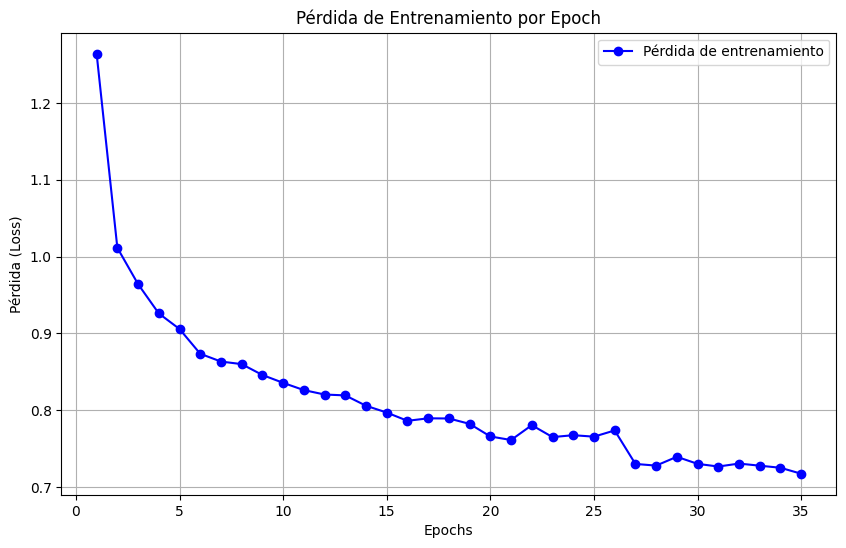

In [ ]:
# Evolución de la función de pérdida en entrenamiento.

import matplotlib.pyplot as plt

# Obtener los valores de pérdida (loss) y pérdida de validación (val_loss) del historial
loss = h.history['loss']
epochs = range(1, len(loss) + 1) # Crear un rango de epochs

# Configurar la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Pérdida de entrenamiento')

# Añadir títulos y etiquetas
plt.title('Pérdida de Entrenamiento por Epoch')
plt.xlabel('Epochs')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

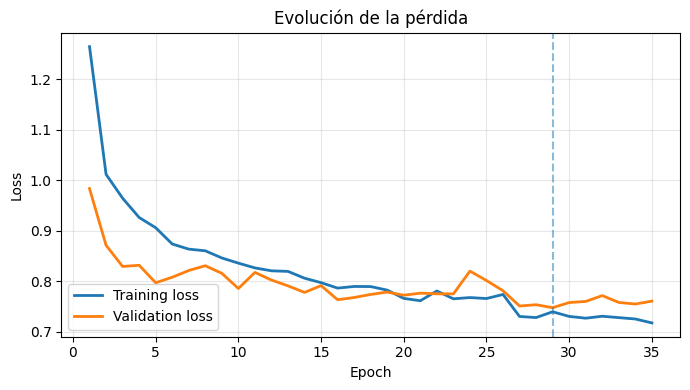

In [ ]:
# Evolución de las funciones de pérdida de entrenamiento y validación.

train_loss = h.history['loss']
val_loss   = h.history['val_loss']
epochs_axis = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs_axis, train_loss, label='Training loss', linewidth=2)
plt.plot(epochs_axis, val_loss,   label='Validation loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolución de la pérdida')
plt.legend()
plt.grid(alpha=0.3)

# Marca visual del mejor epoch según val_accuracy (reutilizamos best_idx)
plt.axvline(best_idx + 1, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


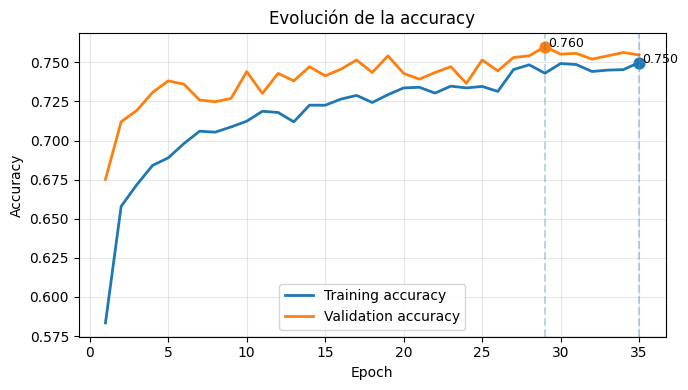

In [ ]:
# Evolución de accuracy para entrenamiento y validación.

train_acc = h.history['accuracy']
val_acc   = h.history['val_accuracy']

epochs_axis = np.arange(1, len(train_acc) + 1)

# Índice (0-based) y valor del mejor accuracy de training y validación
best_train_idx = np.argmax(train_acc)
best_val_idx   = np.argmax(val_acc)

best_train_acc = train_acc[best_train_idx]
best_val_acc   = val_acc[best_val_idx]

plt.figure(figsize=(7,4))
plt.plot(epochs_axis, train_acc, label='Training accuracy', linewidth=2)
plt.plot(epochs_axis, val_acc,   label='Validation accuracy', linewidth=2)

# Puntos marcando el mejor accuracy de cada curva
plt.scatter(best_train_idx + 1, best_train_acc, s=60, marker='o')
plt.scatter(best_val_idx   + 1, best_val_acc,   s=60, marker='o')

# Líneas verticales opcionales
plt.axvline(best_train_idx + 1, linestyle='--', alpha=0.3)
plt.axvline(best_val_idx   + 1, linestyle='--', alpha=0.3)

# Anotaciones con el valor
plt.annotate(f'{best_train_acc:.3f}',
             xy=(best_train_idx + 1, best_train_acc),
             xytext=(best_train_idx + 1 + 0.2, best_train_acc),
             fontsize=9)

plt.annotate(f'{best_val_acc:.3f}',
             xy=(best_val_idx + 1, best_val_acc),
             xytext=(best_val_idx + 1 + 0.2, best_val_acc),
             fontsize=9)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolución de la accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### **Segunda fase del entrenamiento**

A continuación, realizamos la segunda fase del entrenamiento, entrenando durante menos épocas, descongelando unas pocas capas del backbone, añadiendo OneCycleLR y regularización LabelSmoothing (entre otras).

In [ ]:
len(base.layers)

base.summary()

Model: "swin_tiny_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalize (Normalization)       │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embed (PatchEmbedding)    │ (None, None, None, 96) │         4,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pos_drop (Dropout)              │ (None, None, None, 96) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers.0 (BasicLayer)           │ (None, None, None, 96) │       224,694 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers.0.downsample             │ (None, None, None,     │        74,496 │
│ (PatchMerging)                  │ 192)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers.1 (BasicLayer)           │ (None, None, None,     │       891,756 │
│                                 │ 192)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers.1.downsample             │ (None, None, None,     │       296,448 │
│ (PatchMerging)                  │ 384)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers.2 (BasicLayer)           │ (None, None, None,     │    10,658,952 │
│                                 │ 384)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers.2.downsample             │ (None, None, None,     │     1,182,720 │
│ (PatchMerging)                  │ 768)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layers.3 (BasicLayer)           │ (None, None, None,     │    14,183,856 │
│                                 │ 768)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm (LayerNormalization)       │ (None, None, None,     │         1,536 │
│                                 │ 768)                   │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,519,354 (104.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,519,354 (104.98 MB)

**OnceCycleLR**

A continuación, definimos una clase para implementar la técnica de **OneCycleLR**, dado que al entrenar durante menos épocas, nos permitirá acelerar la convergencia ajustando dinámicamente la tasa de aprendizaje (subiéndola y bajándola), logrando una optimización más eficiente y estable en menos iteraciones.

In [ ]:
import math
import tensorflow as tf
from tensorflow.keras import backend as K

class OneCycleLR(tf.keras.callbacks.Callback):
    def __init__(
        self,
        max_lr,
        total_steps,
        pct_start=0.3,
        div_factor=25.0,
        final_div_factor=1e4
    ):
        super().__init__()
        self.max_lr = max_lr
        self.total_steps = total_steps
        self.pct_start = pct_start

        # LR inicial y mínimo siguiendo el esquema de fastai
        self.initial_lr = max_lr / div_factor
        self.min_lr = self.initial_lr / final_div_factor

        # Pasos de subida y de bajada
        self.step_up = int(total_steps * pct_start)
        self.step_down = total_steps - self.step_up

        self.step_num = 0  # Contador de batches

    def _anneal_cos(self, start, end, pct):
        cos_out = math.cos(math.pi * pct) + 1
        return end + (start - end) / 2.0 * cos_out

    def on_train_batch_begin(self, batch, logs=None):
        if self.step_num >= self.total_steps:
            return

        if self.step_num < self.step_up:
            # Fase de subida: initial_lr -> max_lr
            pct = self.step_num / max(1, self.step_up)
            lr = self._anneal_cos(self.initial_lr, self.max_lr, pct)
        else:
            # Fase de bajada: max_lr -> min_lr
            pct = (self.step_num - self.step_up) / max(1, self.step_down)
            lr = self._anneal_cos(self.max_lr, self.min_lr, pct)

        self.step_num += 1
        opt = self.model.optimizer

        # Si es un tf.Variable / KerasVariable -> usamos assign
        if hasattr(opt.learning_rate, "assign"):
            opt.learning_rate.assign(lr)
        else:
            # Si fuera un float u otro tipo, lo sobrescribimos directamente
            opt.learning_rate = lr



In [ ]:
from tensorflow.keras.optimizers import Adam

# Hacemos entrenable la base.
base.trainable = True

# Congelamos las capas "bajas" y dejamos libres solo las últimas 3 capas.
for layer in base.layers[:-3]:
    layer.trainable = False

# También reducimos el learning rate para evitar modificar muchos los pesos.
opt = AdamW(learning_rate=1e-4, weight_decay=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)

# Añadimos label smoothing.
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    label_smoothing=0.1,
    from_logits=False
)

model.compile(
    optimizer=opt,
    loss=loss_fn,
    metrics=['accuracy']
)

print('Training full model')
epochs = 15 #Hacemos pocas épocas.
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)

total_steps = train_steps * epochs

# Ajustamos el learning rate máximo.
max_lr = 3e-4

onecycle_cb = OneCycleLR(
    max_lr=max_lr,
    total_steps=total_steps,
    pct_start=0.3,      # 30% warmup, 70% cooldown
    div_factor=25.0,    # initial_lr = max_lr / 25
    final_div_factor=1e4  # min_lr = initial_lr / 1e4
)

# Añadimos a las callbacks el OneCycleLR.
callbacks = [model_checkpoint, early_stop, terminate, onecycle_cb]

h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=2)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training full model
Epoch 1/15

Epoch 1: val_accuracy did not improve from 0.76000
264/264 - 415s - 2s/step - accuracy: 0.7390 - loss: 1.4215 - val_accuracy: 0.7568 - val_loss: 1.4772
Epoch 2/15

Epoch 2: val_accuracy did not improve from 0.76000
264/264 - 386s - 1s/step - accuracy: 0.7405 - loss: 1.3381 - val_accuracy: 0.7520 - val_loss: 1.3379
Epoch 3/15

Epoch 3: val_accuracy did not improve from 0.76000
264/264 - 387s - 1s/step - accuracy: 0.7324 - loss: 1.2751 - val_accuracy: 0.7563 - val_loss: 1.2754
Epoch 4/15

Epoch 4: val_accuracy improved from 0.76000 to 0.76480, saving model to model.keras
264/264 - 387s - 1s/step - accuracy: 0.7464 - loss: 1.2091 - val_accuracy: 0.7648 - val_loss: 1.1783
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0.76480
264/264 - 387s - 1s/step - accuracy: 0.7618 - loss: 1.1574 - val_accuracy: 0.7643 - val_loss: 1.1742
Epoch 6/15

Epoch 6: val_accuracy improved from 0.76480 to 0.77707, saving model to model.keras
264/264 - 388s - 1s/step - accu

**Añadimos las gráficas para la visualización de la segunda fase del entrenamiento**

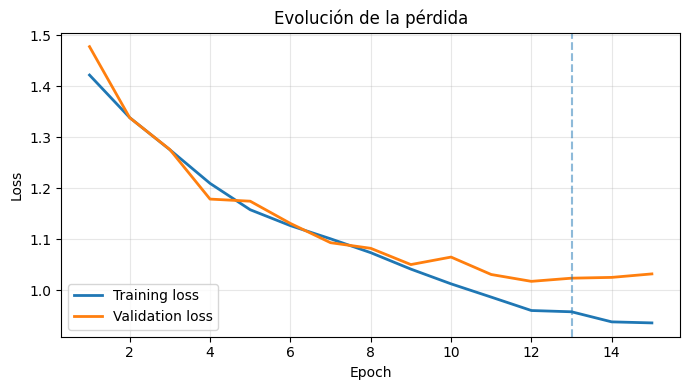

In [ ]:
# Test overfitting

train_loss = h.history['loss']
val_loss   = h.history['val_loss']
epochs_axis = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs_axis, train_loss, label='Training loss', linewidth=2)     # línea 1 (color automático)
plt.plot(epochs_axis, val_loss,   label='Validation loss', linewidth=2)   # línea 2 (otro color)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolución de la pérdida')
plt.legend()
plt.grid(alpha=0.3)

# Marca visual del mejor epoch según val_accuracy (reutilizamos best_idx)
plt.axvline(best_idx + 1, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


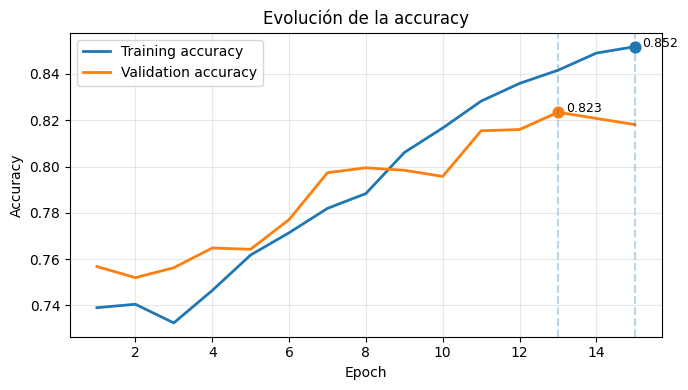

In [ ]:
# Evolución de accuracy en entrenamiento y validación.

train_acc = h.history['accuracy']
val_acc   = h.history['val_accuracy']

epochs_axis = np.arange(1, len(train_acc) + 1)

# Índice (0-based) y valor del mejor accuracy de training y validación
best_train_idx = np.argmax(train_acc)
best_val_idx   = np.argmax(val_acc)

best_train_acc = train_acc[best_train_idx]
best_val_acc   = val_acc[best_val_idx]

plt.figure(figsize=(7,4))
plt.plot(epochs_axis, train_acc, label='Training accuracy', linewidth=2)
plt.plot(epochs_axis, val_acc,   label='Validation accuracy', linewidth=2)

# Puntos marcando el mejor accuracy de cada curva
plt.scatter(best_train_idx + 1, best_train_acc, s=60, marker='o')
plt.scatter(best_val_idx   + 1, best_val_acc,   s=60, marker='o')

# Líneas verticales opcionales
plt.axvline(best_train_idx + 1, linestyle='--', alpha=0.3)
plt.axvline(best_val_idx   + 1, linestyle='--', alpha=0.3)

# Anotaciones con el valor
plt.annotate(f'{best_train_acc:.3f}',
             xy=(best_train_idx + 1, best_train_acc),
             xytext=(best_train_idx + 1 + 0.2, best_train_acc),
             fontsize=9)

plt.annotate(f'{best_val_acc:.3f}',
             xy=(best_val_idx + 1, best_val_acc),
             xytext=(best_val_idx + 1 + 0.2, best_val_acc),
             fontsize=9)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolución de la accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Validation
Computamos las métricas de validación.

In [ ]:
import numpy as np

model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

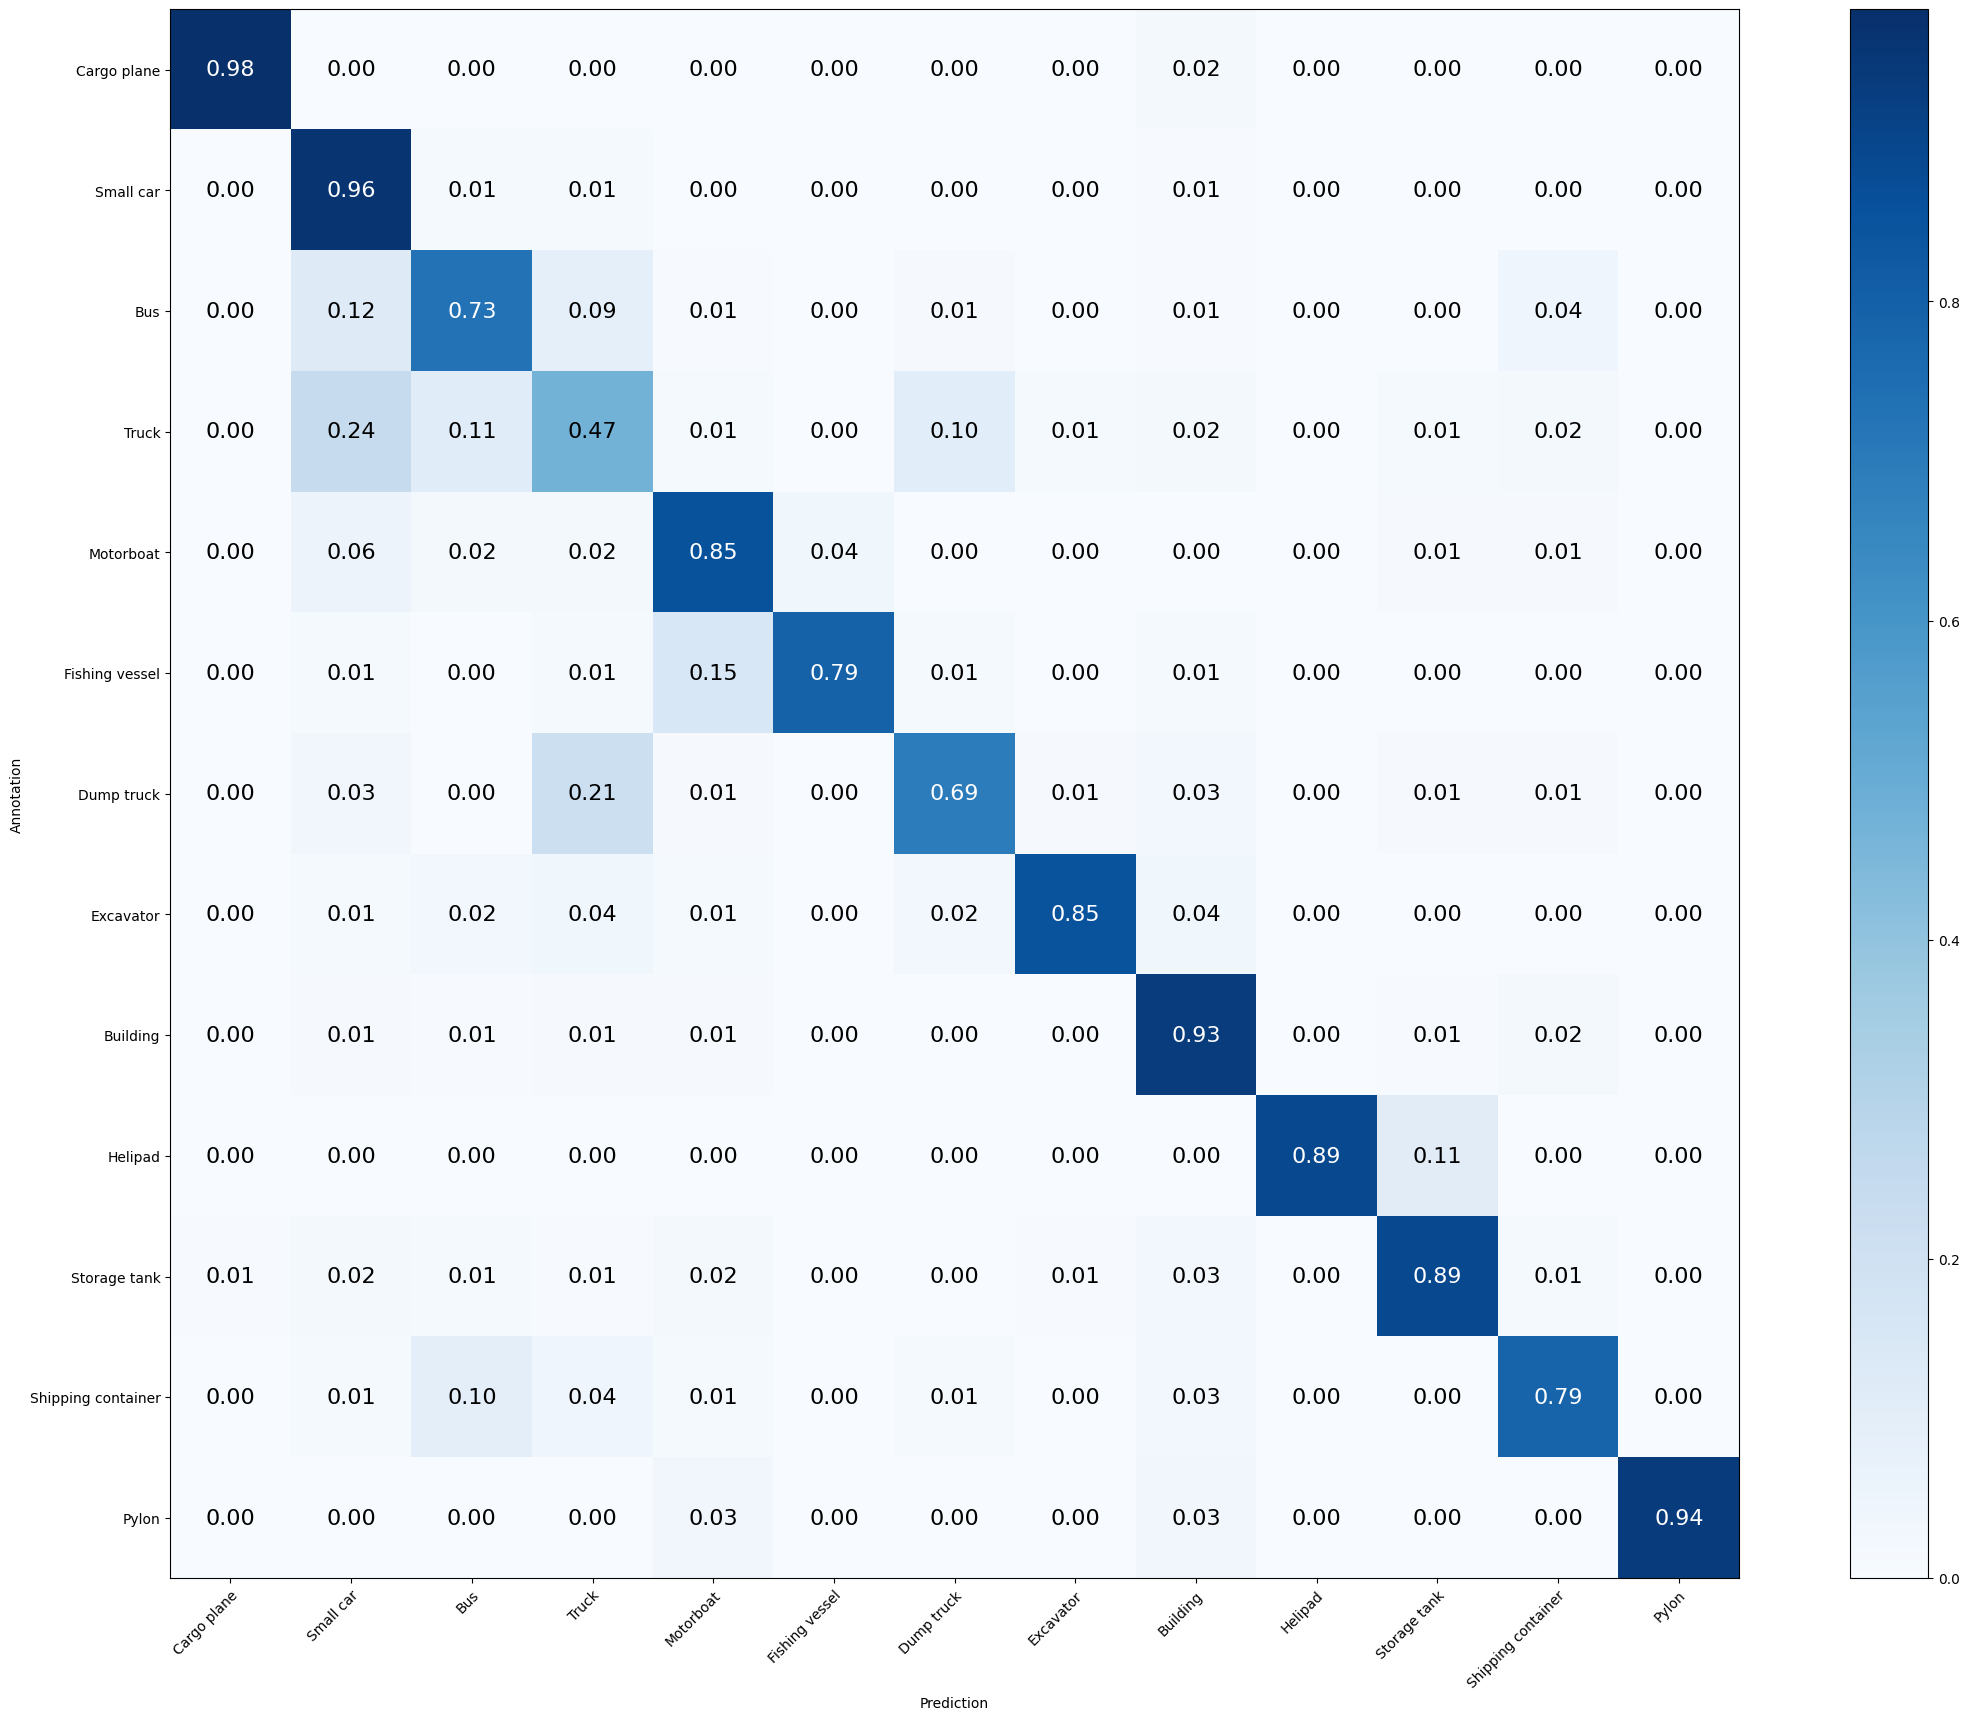

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 81.813%
Mean Recall: 82.849%
Mean Precision: 85.707%
> Cargo plane: Recall: 98.305% Precision: 98.305% Specificity: 99.945% Dice: 98.305%
> Small car: Recall: 96.049% Precision: 75.962% Specificity: 93.532% Dice: 84.832%
> Bus: Recall: 72.989% Precision: 70.950% Specificity: 96.943% Dice: 71.955%
> Truck: Recall: 46.888% Precision: 64.943% Specificity: 96.267% Dice: 54.458%
> Motorboat: Recall: 85.321% Precision: 77.500% Specificity: 98.471% Dice: 81.223%
> Fishing vessel: Recall: 79.452% Precision: 93.548% Specificity: 99.778% Dice: 85.926%
> Dump truck: Recall: 69.492% Precision: 70.690% Specificity: 98.065% Dice: 70.085%
> Excavator: Recall: 85.185% Precision: 93.243% Specificity: 99.721% Dice: 89.032%
> Building: Recall: 93.388% Precision: 93.132% Specificity: 98.347% Dice: 93.260%
> Helipad: Recall: 88.889% Precision: 100.000% Specificity: 100.000% Dice: 94.118%
> Storage tank: Recall: 88.816% Precision: 93.750% Specificity: 99.478% Dice: 91.216%
> Shipping containe

#### Testing

In [ ]:
import os
import numpy as np
base_path = '/kaggle/input/xview-recognition/'

anns = []
for (dirpath, dirnames, filenames) in os.walk('/kaggle/input/xview-recognition/xview_test/'):
    for filename in filenames:

        image = GenericImage(dirpath[31:] + '/' + filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [ ]:
import numpy as np

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [ ]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)